# Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.restoration import unwrap_phase

def calc_phase(I):
    I1, I2, I3, I4 = I  # unpacking the pixel intensity images 
    # using numpy.arctan2 : returns angle [-pi, pi]
    return np.arctan2( (I4 - I2), (I1 - I3) )

def calc_Z(phase_diff, L, p, d):
    return L - (L * p * phase_diff) / (2*np.pi*d + p*phase_diff)

def load_images(folder_path, filename, ROI, blur_size):
    I = []
    for i in range(4):
        img = cv2.imread(folder_path + f"{filename} {i+1}.jpg")
        grey = cv2.cvtColor(img[ROI], cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(grey, blur_size, -1)
        blur = blur.astype(np.int16)            # convert to 16 bit to avoid overflow and allow negative values
        I.append(blur)
    return I

def reconstruct_3d(phase_diff, L, p, d, view=[[5, 50], [30, 135]]):
    # Calculation of Z (depth)
    Z = calc_Z(phase_diff, L, p, d)
    view1, view2 = view

    # 3D reconstruct
    x = np.linspace(0, Z.shape[1], Z.shape[1])
    y = np.linspace(0, Z.shape[0], Z.shape[0])
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis')
    ax1.set_title('3D reconstruct')
    ax1.set_xlabel("X coords")
    ax1.set_ylabel("Y coords")
    ax1.set_zlabel("Z coords")
    ax1.view_init(view1[0], view1[1])

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, Z, cmap='viridis')
    ax2.set_title('3D reconstruct')
    ax2.set_xlabel("X coords")
    ax2.set_ylabel("Y coords")
    ax2.set_zlabel("Z coords")
    ax2.view_init(view2[0], view2[1])

    plt.tight_layout()
    plt.show()

def plot_images(imgs, titles):
    if type(titles) == str:
        titles = [titles]
    N = len(imgs)
    plt.figure(figsize=(6*N,12))
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f'{titles[i % len(titles)]} {i+1}')
        plt.axis('off')
    plt.show()

$$
Z_w (x,y) = L \frac{p~\delta(x,y)}{2\pi d + p~\delta(x,y)}
$$

# Creating the patterns

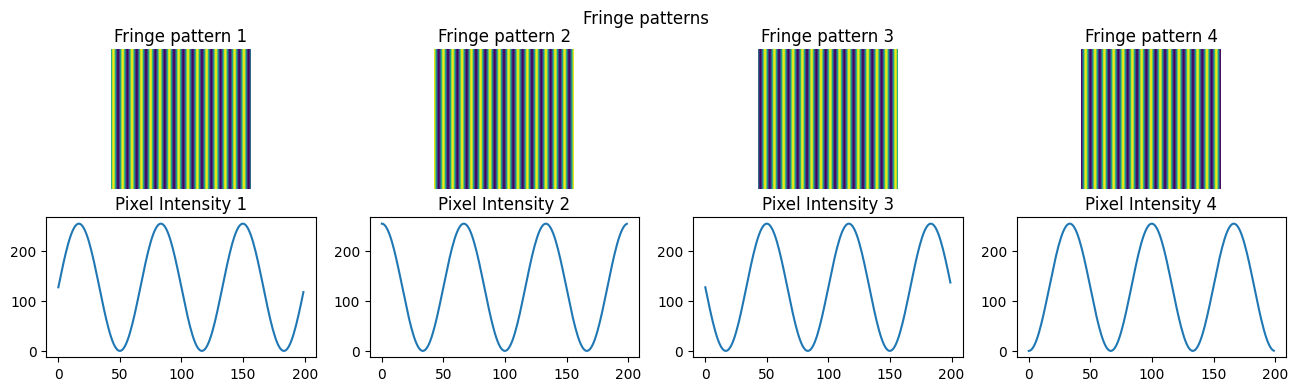

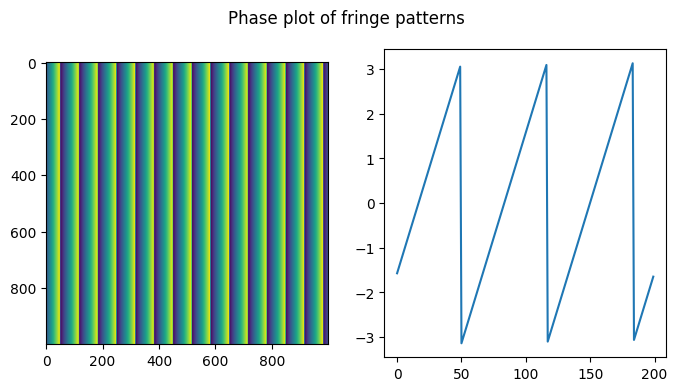

In [22]:
f = 15              # fringe frequency
num_pts = 1000      # resolution / number of points
N = 4               # Number of phase shift

x = np.linspace(0, 2*np.pi * f, num_pts)
y = np.linspace(0, 2*np.pi * f, num_pts)
X, Y = np.meshgrid(x, y)
I_fringe = [0,0,0,0]
for i in range(N):
    phase = 2*np.pi/N * i
    I_fringe[i] = (np.sin(X + phase) + 1) / 2 * 255

# Plot images of fringe patterns and their pixel intensities
plt.figure(figsize=(16,4))
plt.suptitle("Fringe patterns")
for i, I in enumerate(I_fringe):
    plt.subplot(2, 4, i+1)
    plt.imshow(I_fringe[i])
    plt.title(f'Fringe pattern {i+1}')
    plt.axis('off')

    plt.subplot(2, 4, i+5)
    plt.plot(I[150,:200])
    plt.title(f"Pixel Intensity {i+1}")
plt.show()

# Calculate phase from fringe patterns and plot
phase_fringe = calc_phase(I_fringe)
plt.figure(figsize=(8,4))
plt.suptitle("Phase plot of fringe patterns")
plt.subplot(1,2,1)
plt.imshow(phase_fringe)
plt.subplot(1,2,2)
plt.plot(phase_fringe[0,:200])
plt.show()

# Data & Calculation

## Pingpong & Hole

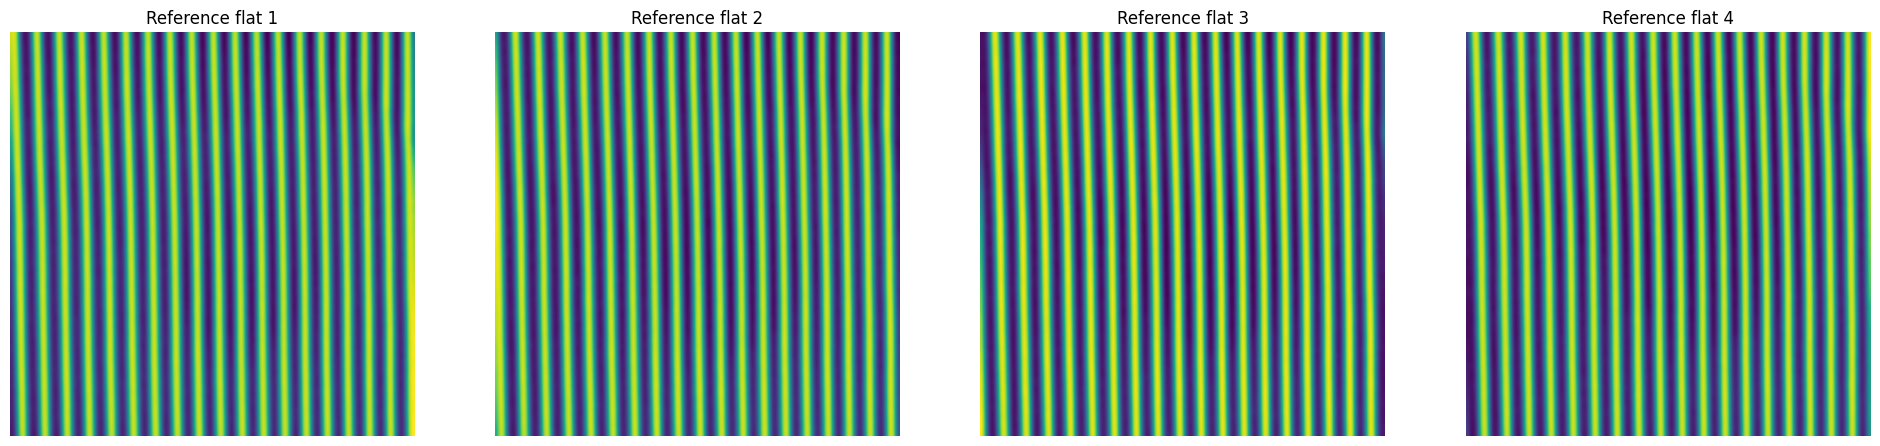

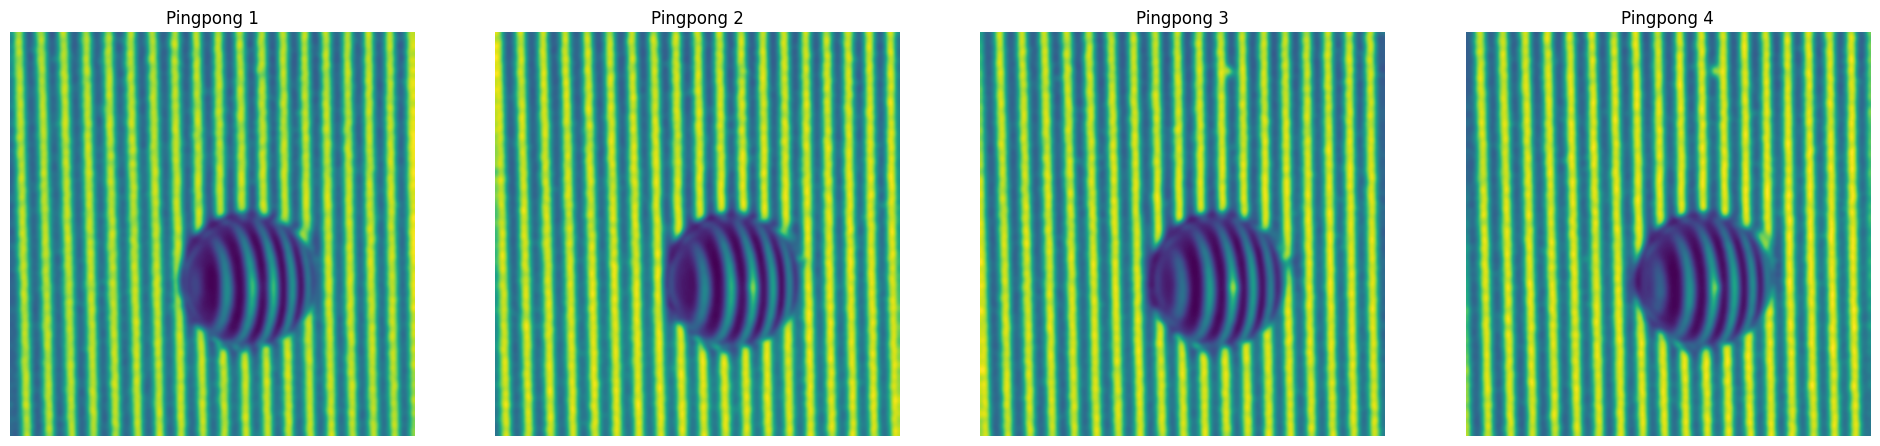

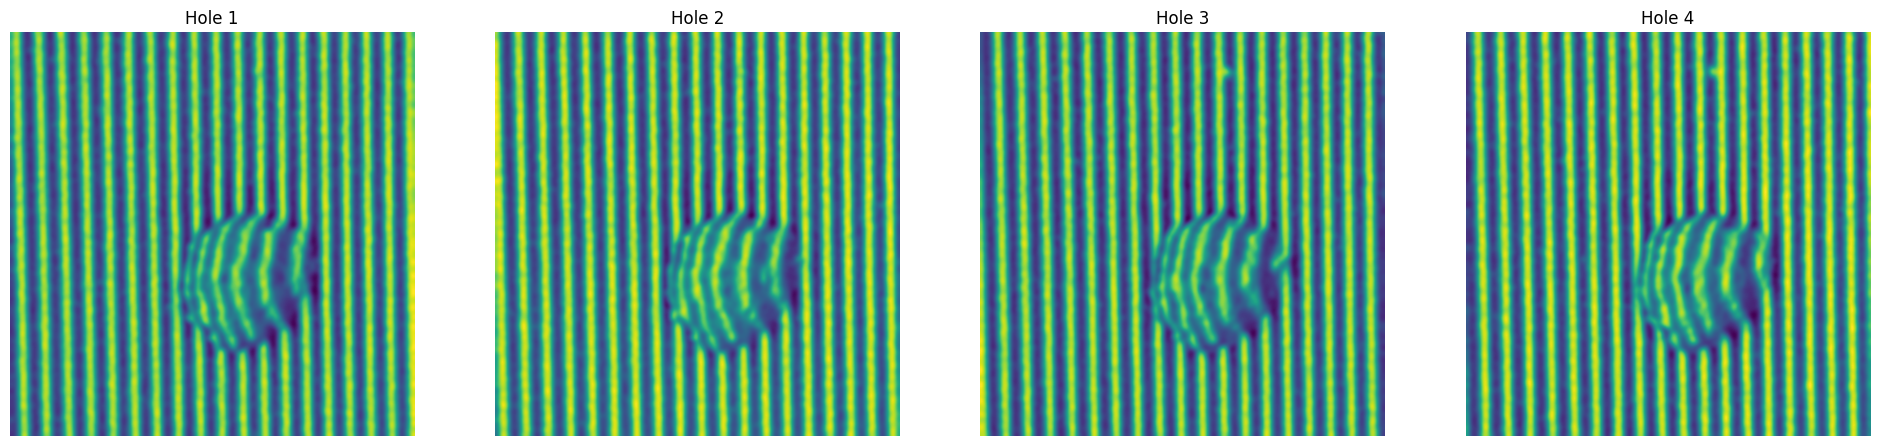

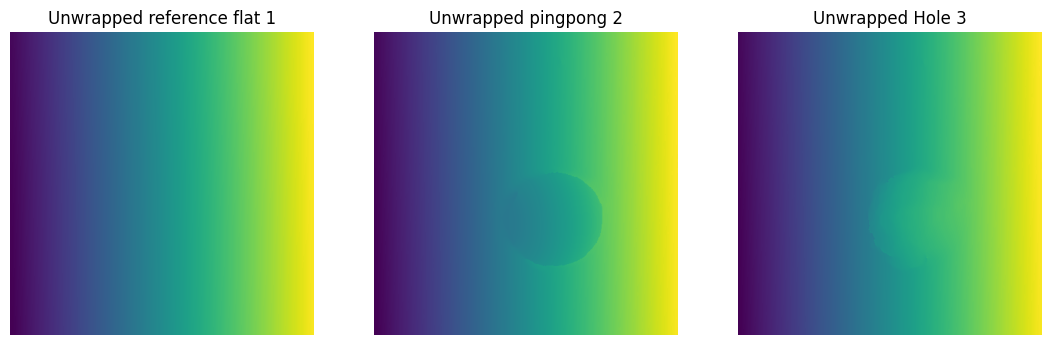

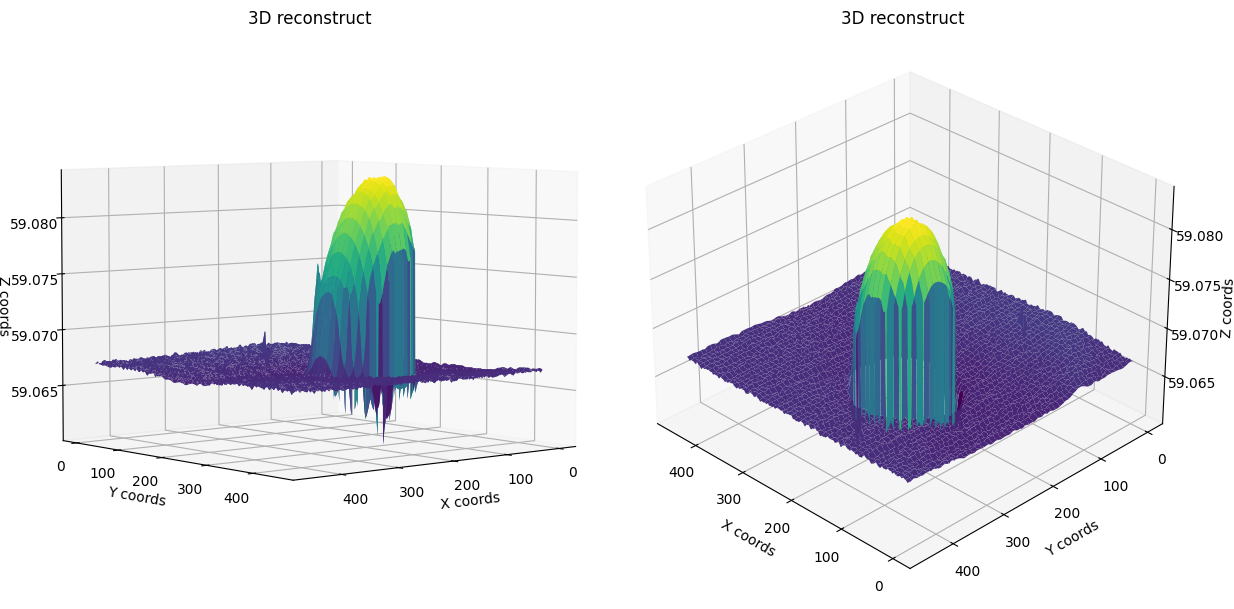

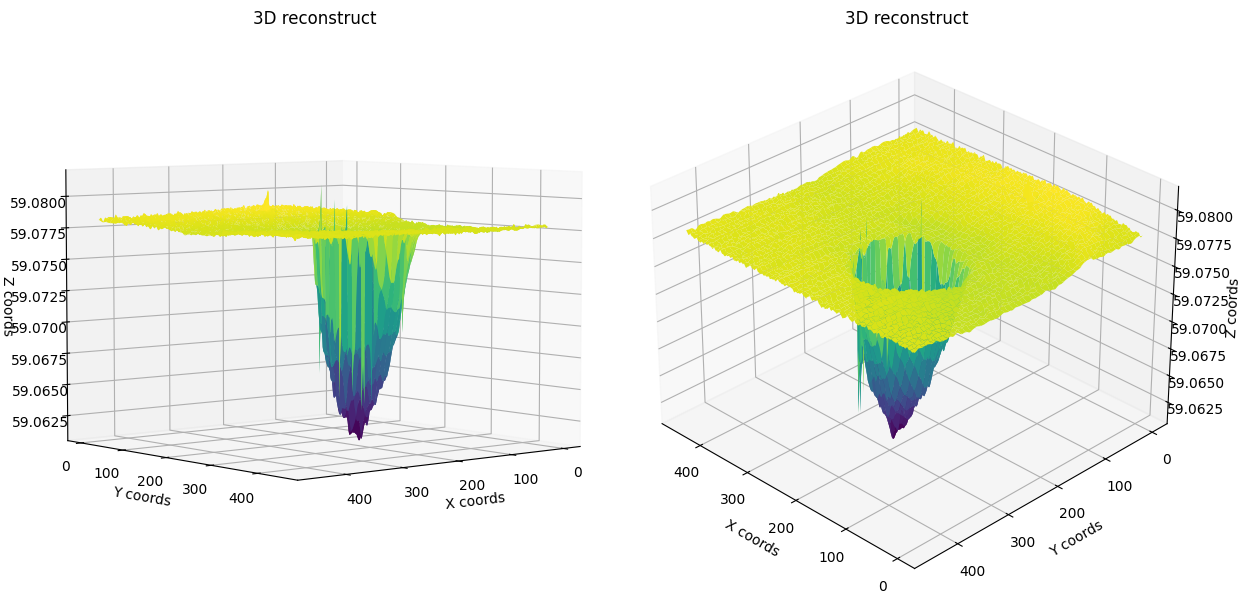

In [21]:
N = 4
ROI = (slice(200, 650), slice(450, 900))
blur_size = (17,17)

# Load the images
folder_path = "images/pingpong_high_frequency_fringe/"

I_reference = load_images(folder_path, "flat", ROI, blur_size)
plot_images(I_reference, "Reference flat")

I_pingpong = load_images(folder_path, "pingpong", ROI, blur_size)
plot_images(I_pingpong, "Pingpong")

I_hole = load_images(folder_path, "hole", ROI, blur_size)
plot_images(I_hole, "Hole")

# Calculate phases
phase_reference = calc_phase(I_reference)
phase_pingpong = calc_phase(I_pingpong)
phase_hole = calc_phase(I_hole)

# Phase unwrapping
phase_pingpong = unwrap_phase(phase_pingpong)
phase_reference = unwrap_phase(phase_reference)
phase_hole = unwrap_phase(phase_hole)

# Show unwrapped phase plots
phases = [phase_reference, phase_pingpong, phase_hole]
plot_titles = ["Unwrapped reference flat", "Unwrapped pingpong", "Unwrapped Hole"]
plot_images(phases, plot_titles)

# Setup parameters
L = 59.2
p = 1/200
d = 24

# Calculation of phase difference between object and reference phase
phase_diff_pingpong = phase_pingpong - phase_reference
phase_diff_hole = phase_hole - phase_reference

phase_diff_pingpong = np.flip(phase_diff_pingpong, axis=1)
phase_diff_hole = np.flip(phase_diff_hole, axis=1)

# Show 3D reconstructions
reconstruct_3d(phase_diff_pingpong, L, p, d)
reconstruct_3d(phase_diff_hole, L, p, d)

## 911

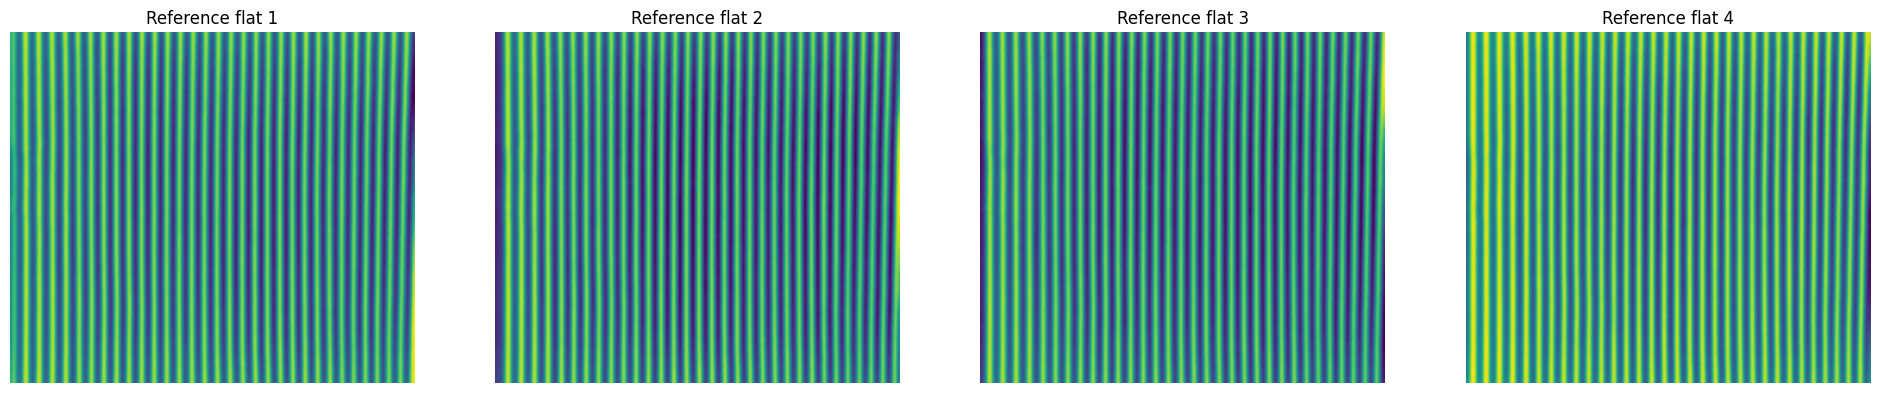

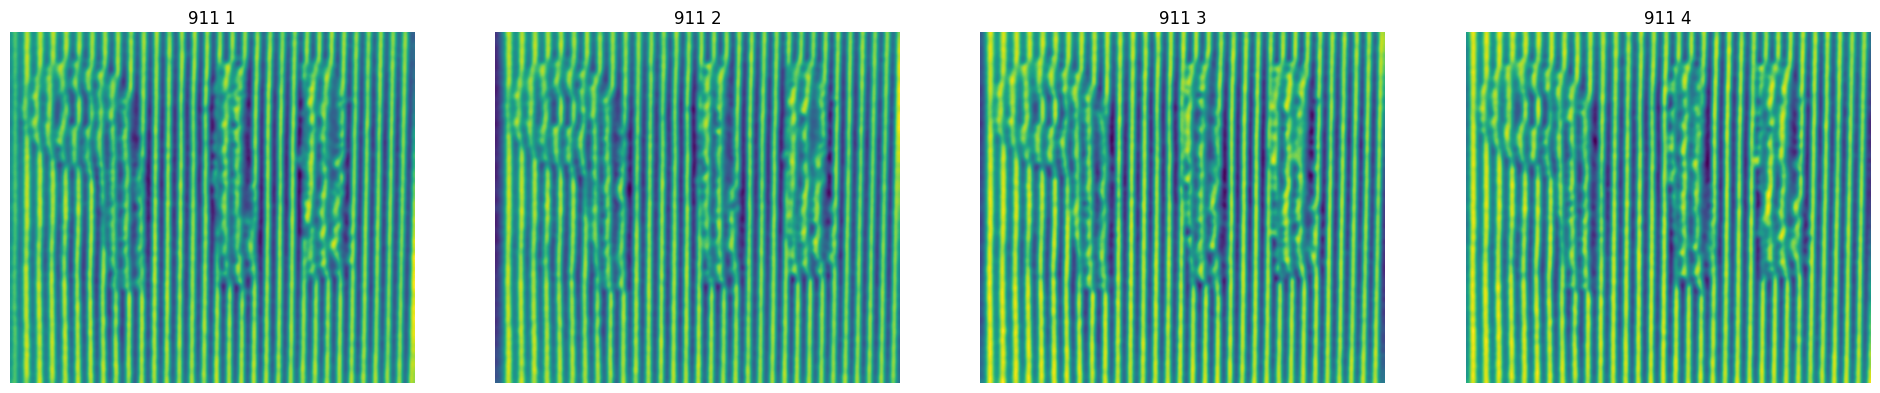

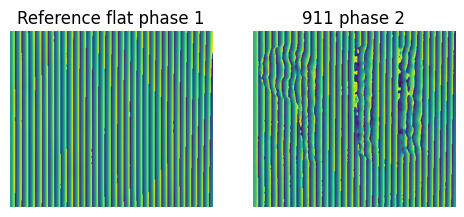

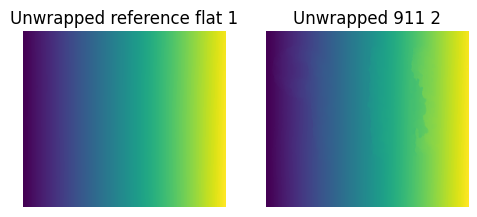

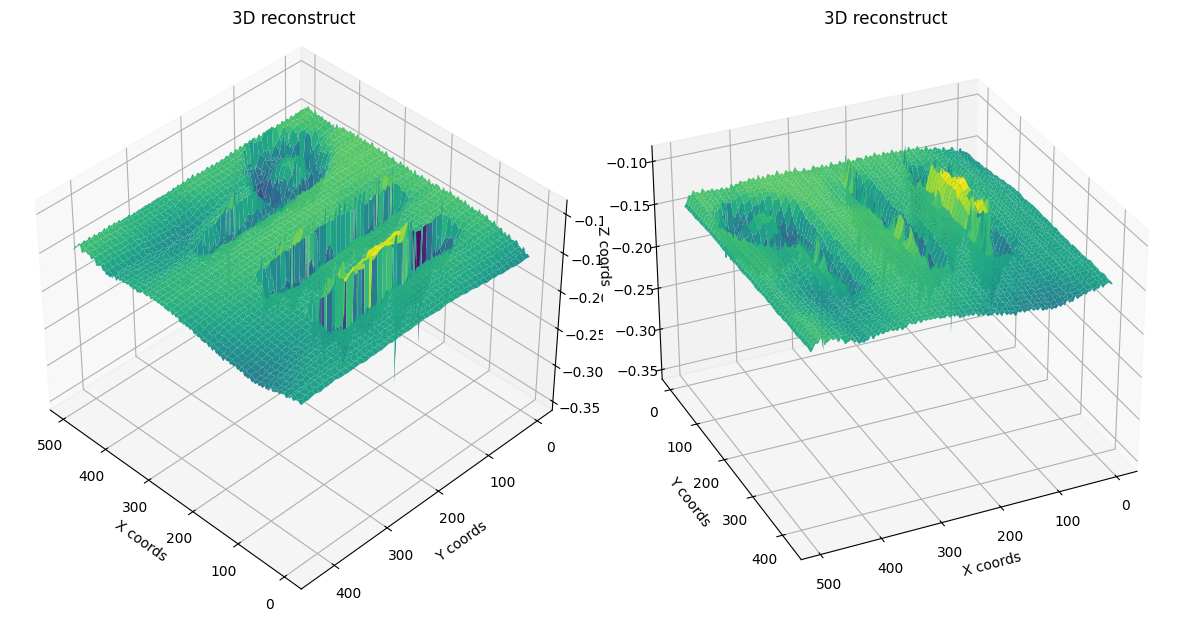

In [ ]:
N = 4
ROI = (slice(120, 550), slice(630, 1300))
blur_size = (17,17)

# Load the images
folder_path = "images/911/"

I_reference = load_images(folder_path, "flat", ROI, blur_size)
plot_images(I_reference, "Reference flat")

I_911 = load_images(folder_path, "911", ROI, blur_size)
plot_images(I_911, "911")

# Calculate phase
phase_reference = calc_phase(I_reference)
phase_911 = calc_phase(I_911)
# Show phase plots
phases = [phase_reference, phase_911]
plot_titles = ["Reference flat phase", "911 phase"]
plot_images(phases, plot_titles)

# Phase unwrapping
phase_reference = unwrap_phase(phase_reference)
phase_911 = unwrap_phase(phase_911)

# Show unwrapped phase plots
phases = [phase_reference, phase_911]
plot_titles = ["Unwrapped reference flat", "Unwrapped 911"]
plot_images(phases, plot_titles)

# Setup parameters
L = 24
p = 1136
d = 13

# Calculation of phase difference between object and reference phase
phase_diff_911 = phase_911 - phase_reference
phase_diff_911 = np.flip(phase_diff_911, axis=1)

# Calculation of Z (depth)
Z = calc_Z(phase_diff_911, L, p, d)

# Show 3D reconstruction
reconstruct_3d(phase_diff_911, L, p, d, view=[[40, 135], [30, 65]])